# *Monod* demonstration: distinguishing models of transcriptional variation

We ran the *Monod* inference pipeline on thirteen datasets: pre-clustered mouse brain cell data, disaggregated into GABAergic and glutamatergic cell types, and five 10X Genomics mouse tissue samples. Each dataset was fit using the bursty, constitutive, extrinsic, and CIR models for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given maximum likelihood estimates under each model, we can apply the standard Akaike Information Criterion framework to attempt to assign probabilities to the models. These estimates are necessarily incomplete, as they do not take into account the parameter uncertainties; further, they appear to overestimate confidence in model selections. However, this is an essential first step toward exploring model ensembles. 

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [3]:
models = ('Bursty','Constitutive','Extrinsic','CIR')

In [4]:
n_models = len(models)

In [5]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dn1 = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 

dir_string1 = './fits/gg_220527_021_allen_celltypes_1'

res = [dir_string1+'/'+x for x in dn1]

dn2 =  ['heart_1k','heart_10k','neuron_1k','neuron_10k','brain_5k']
dn2 = [x+'_v3' for x in dn2]
dataset_names = dn1 + dn2

dir_string2 = './fits/gg_220526_021_modelcomp_1'
res += [dir_string2+'/'+x for x in dn2]

result_strings = [[x+'/'+model+'_Poisson_20x21/grid_scan_results.res' for model in models] for x in res]

sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] + [dir_string2+'/'+x+'/raw.sd' for x in dn2]


In [8]:
n_datasets = len(sd_strings)

## AIC weight computation

Now, we iterate over the results for all of the models, identify the parameter optima, and compute Akaike weights according to the procedure in Burnham and Anderson (2002).

INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Constitutive_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Extrinsic_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/CIR_Poisson_20x21/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/AIC_comparison_allen_A08_gaba.png.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results.r

INFO:root:Grid scan results loaded from ./fits/gg_220526_021_modelcomp_1/heart_10k_v3/CIR_Poisson_20x21/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220526_021_modelcomp_1/analysis_figures/AIC_comparison_heart_10k_v3.png.
INFO:root:Search data loaded from ./fits/gg_220526_021_modelcomp_1/neuron_1k_v3/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220526_021_modelcomp_1/neuron_1k_v3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220526_021_modelcomp_1/neuron_1k_v3/Constitutive_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220526_021_modelcomp_1/neuron_1k_v3/Extrinsic_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220526_021_modelcomp_1/neuron_1k_v3/CIR_Poisson_20x21/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220526_021_modelcomp_1/analysis_figures/AIC_comparison_neuron_1k_v3.png.
INFO:root:Search data loaded from ./fit

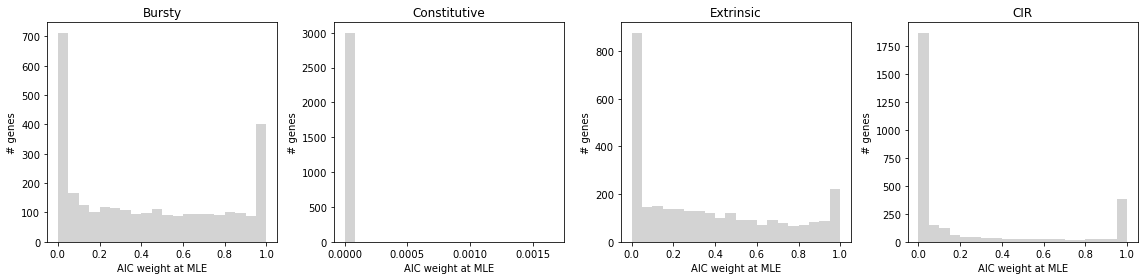

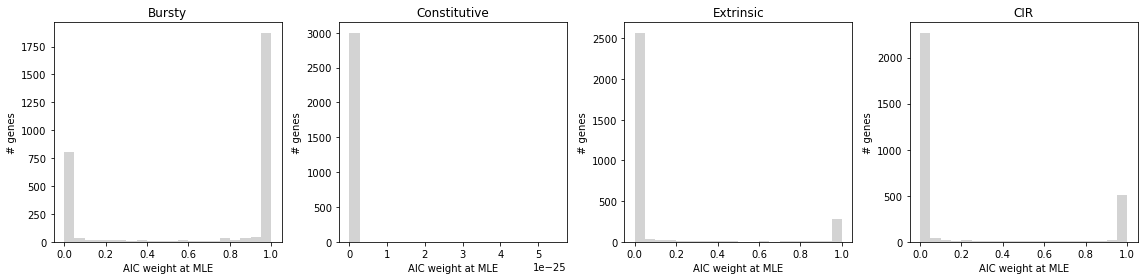

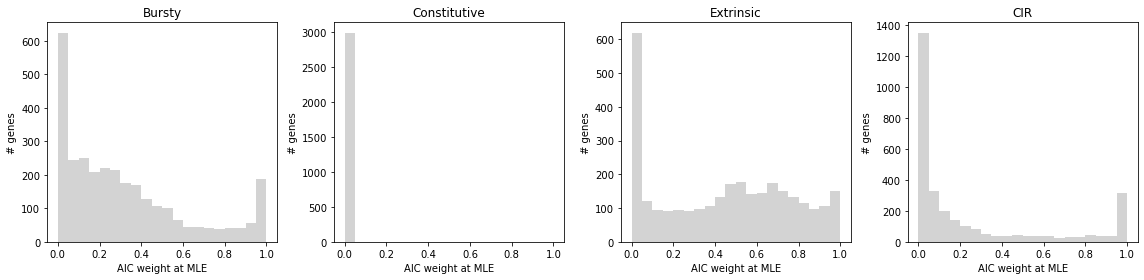

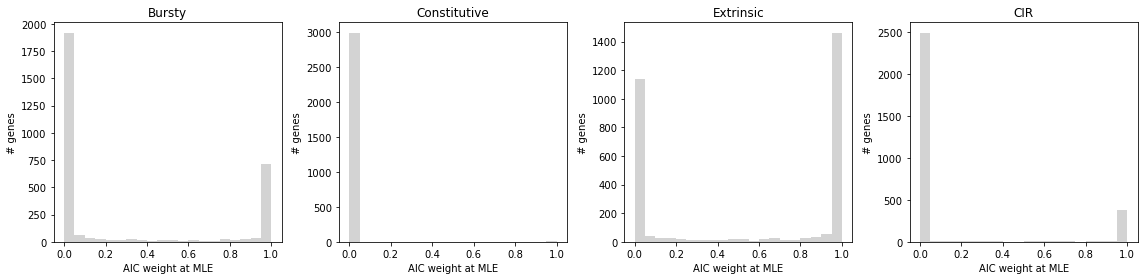

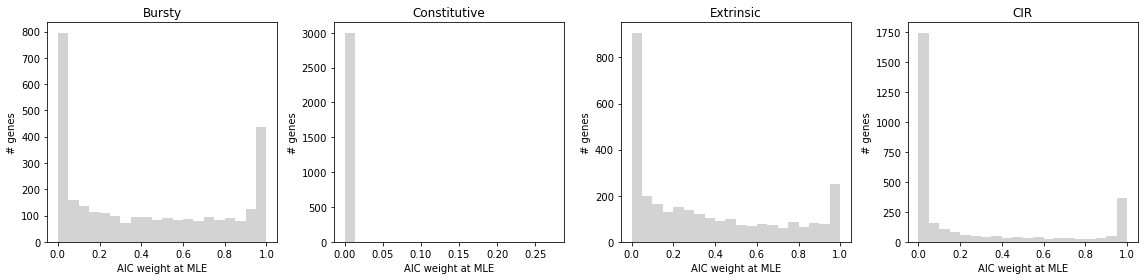

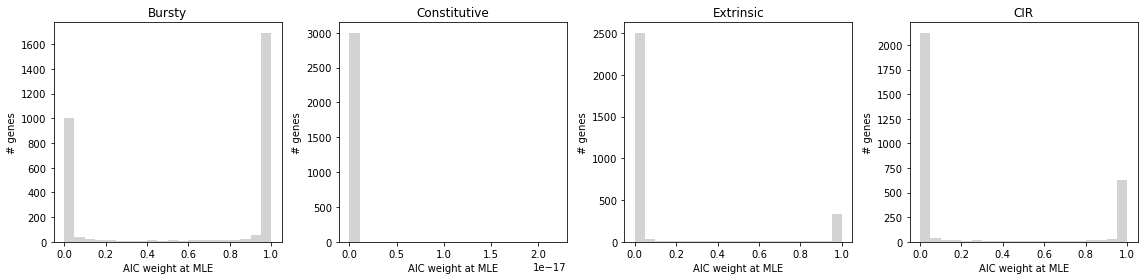

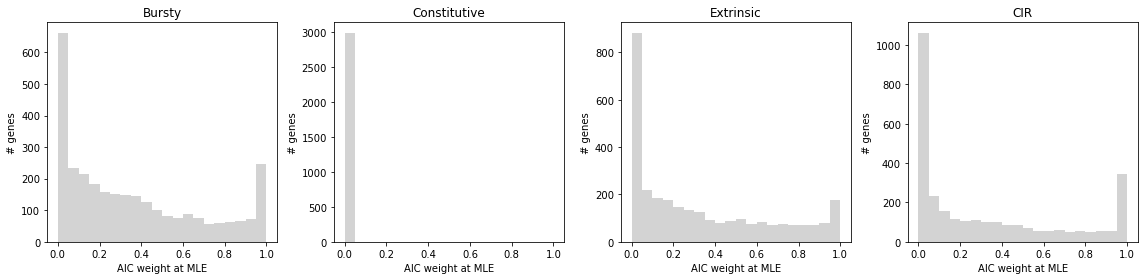

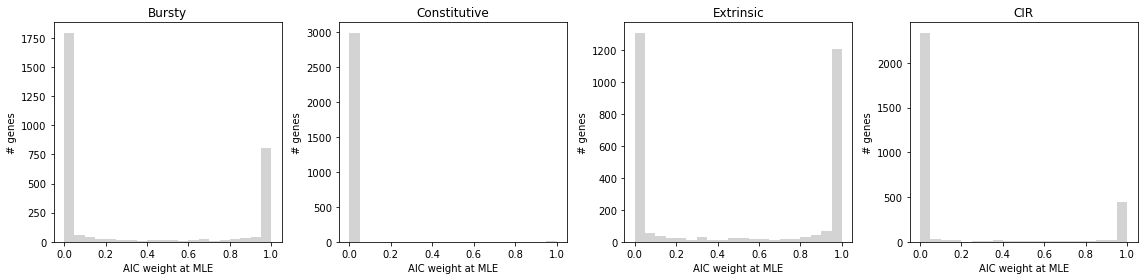

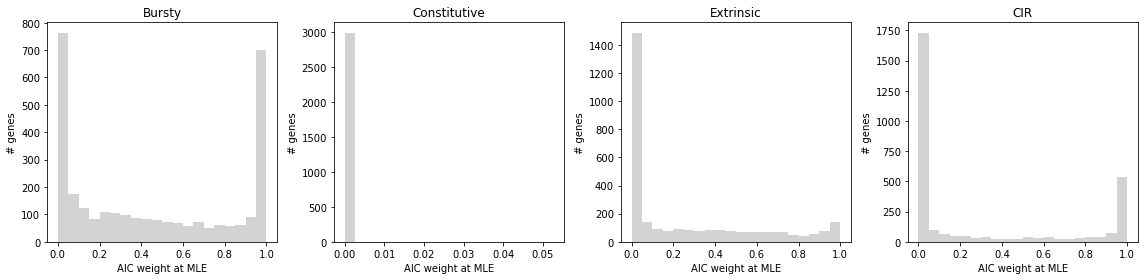

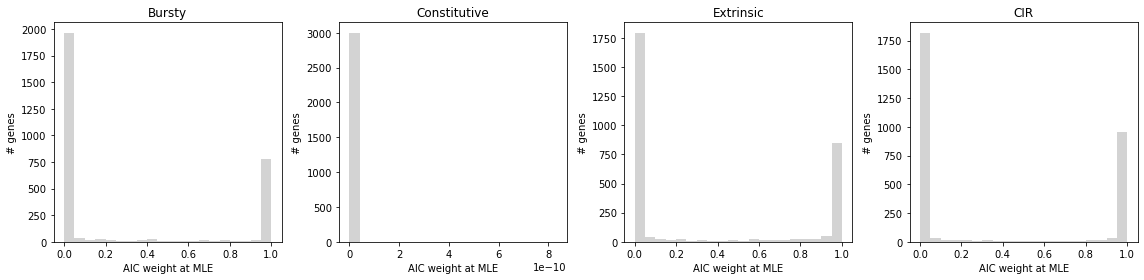

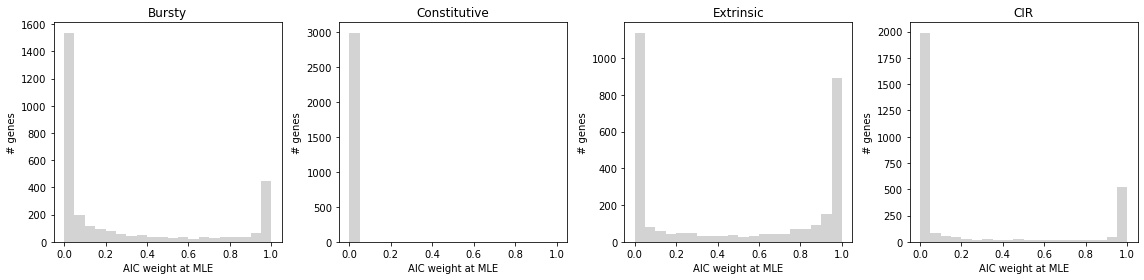

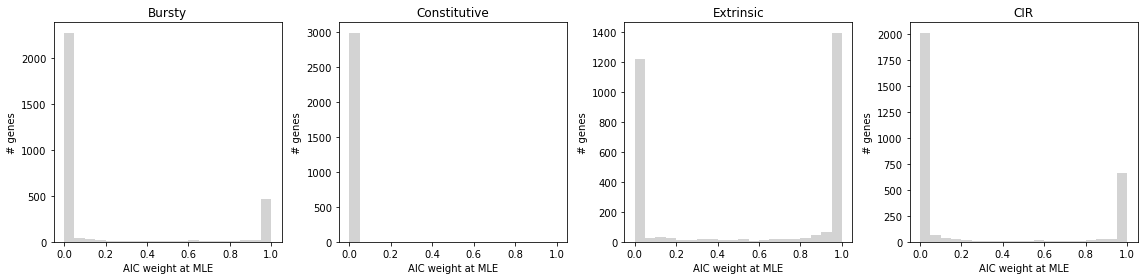

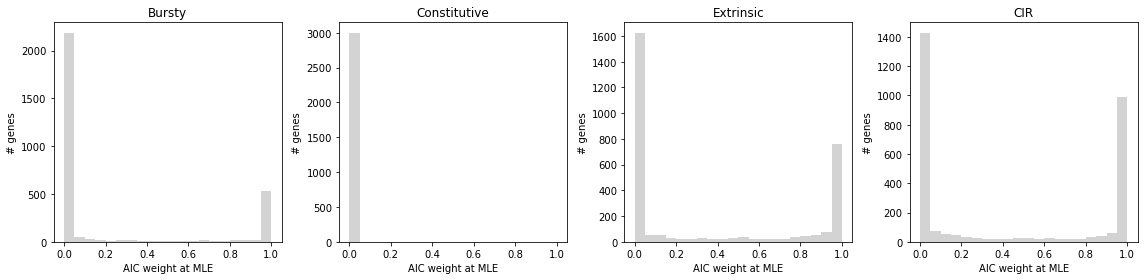

In [9]:
w = []

for j in range(n_datasets):
    rs = result_strings[j]
    
    sd = load_search_data(sd_strings[j])
    
    sr_arr = []
    for k in range(n_models):
        sr = load_search_results(rs[k])
        sr.find_sampling_optimum()
        sr_arr.append(sr)
    
    if j<len(dn1):
        make_batch_analysis_dir(sr_arr,dir_string1)
    else:
        make_batch_analysis_dir(sr_arr,dir_string2)

    w_ = plot_AIC_weights(sr_arr,sd,models,meta=dataset_names[j],savefig=True)
    w.append(w_)

We find that the constitutive model is essentially never selected as the optimal one; biological overdispersion is clearly mandatory to describe scRNA-seq joint distributions. However, surprisingly, we find quite a bit of variation in *which* overdispersed model is optimal.

In [10]:
w = np.asarray(w)

In [11]:
w1 = w[:len(dn1)]

In [12]:
w2 = w[len(dn1):]

In [13]:
dn1_ = [dn1[k] for k in (0,2,4,6,1,3,5,7)]

In [14]:
w1_ = np.asarray([w1[k] for k in (0,2,4,6,1,3,5,7)])

## Inter-dataset comparisons

Nevertheless, despite this instability, we do find certain broadly consistent trends. Technical replicates B08/A08 and B01/C01, when filtered for a particular cell type, tend to give similar weights to the bursty model (KDE has a significant peak at 0 and tends not to have it at 1). GABAergic cells are consistent between biological replicates, but glutamatergic are not, which is somewhat surprising since there are far more glutamatergic cells in the raw datasets.

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/AIC_comparison_grid.png.


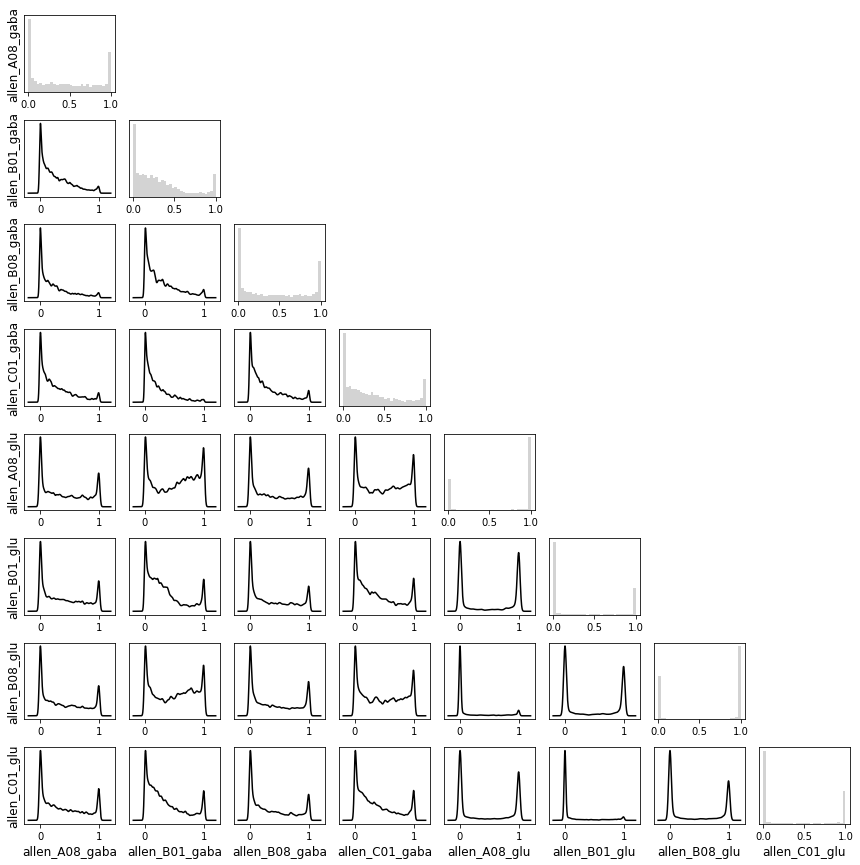

In [15]:
compare_AIC_weights(w1_,dn1_,'./fits/gg_220527_021_allen_celltypes_1/analysis_figures')

INFO:root:Figure stored to ./fits/gg_220526_021_modelcomp_1/analysis_figures/AIC_comparison_grid.png.


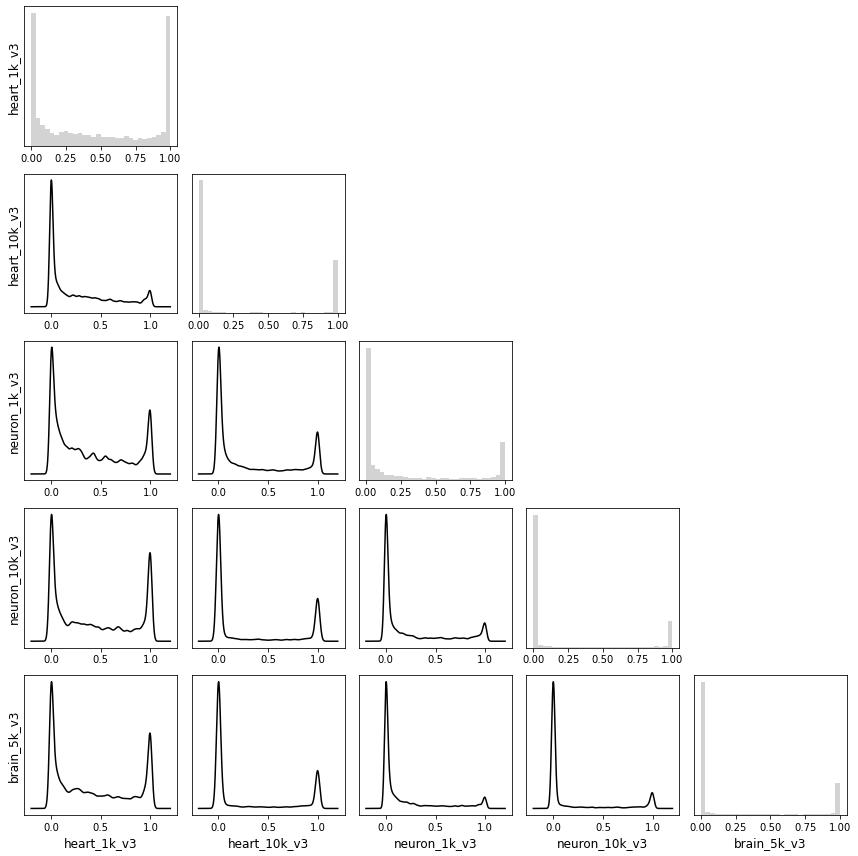

In [16]:
compare_AIC_weights(w2,dn2,'./fits/gg_220526_021_modelcomp_1/analysis_figures')

In [17]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 304 seconds.
